In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               851 non-null    object 
 1   SeasonNumber       851 non-null    int64  
 2   SeasonVersion      851 non-null    int64  
 3   Player             851 non-null    object 
 4   MatchId            851 non-null    object 
 5   Map                851 non-null    object 
 6   Category           851 non-null    object 
 7   Playlist           851 non-null    object 
 8   Input              851 non-null    object 
 9   Queue              851 non-null    object 
 10  PreCsr             851 non-null    int64  
 11  PostCsr            851 non-null    int64  
 12  Rank               851 non-null    int64  
 13  WasAtStart         851 non-null    int64  
 14  WasAtEnd           851 non-null    int64  
 15  WasInProgressJoin  851 non-null    int64  
 16  Mmr                2 non-n

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               591 non-null    int64         
 1   Date                591 non-null    datetime64[ns]
 2   Map                 591 non-null    object        
 3   Category            591 non-null    object        
 4   Rank                591 non-null    int64         
 5   Outcome             591 non-null    int64         
 6   Accuracy            591 non-null    float64       
 7   DamageDone          591 non-null    int64         
 8   DamageTaken         591 non-null    int64         
 9   ShotsFired          591 non-null    int64         
 10  ShotsLanded         591 non-null    int64         
 11  ShotsMissed         591 non-null    int64         
 12  KD                  591 non-null    float64       
 13  KDA                 591 non-null    float64       

In [4]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,591.0,494.269036,204.625314,140.000000,317.500000,490.000000,672.500000,849.000000
Rank,591.0,3.974619,2.152893,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,591.0,0.546531,0.498252,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,591.0,51.763739,5.412336,24.390000,48.525000,51.920000,54.895000,80.560000
DamageDone,591.0,5244.010152,1852.923968,347.000000,3896.000000,5027.000000,6450.500000,12673.000000
DamageTaken,591.0,4465.690355,1561.064357,35.000000,3456.000000,4291.000000,5498.500000,9962.000000
ShotsFired,591.0,236.142132,80.314320,16.000000,180.000000,228.000000,291.500000,517.000000
ShotsLanded,591.0,121.915398,42.736000,4.000000,94.000000,116.000000,150.000000,286.000000
ShotsMissed,591.0,114.226734,40.937232,7.000000,85.000000,111.000000,140.500000,261.000000
KD,591.0,1.272132,0.752356,0.000000,0.860000,1.130000,1.455000,10.000000


In [5]:
# dfr.tail()
round(dfr.sort_values('Csr', ascending=False),2).head(8)

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
576,831,2024-03-08 01:52:40,Solitude,Slayer,4,1,40.71,2102,2790,140,...,1.12,1.17,50.02,28.33,10.06,51.10,7.04,3.46,1092,0.55
575,830,2024-03-07 01:55:14,Aquarius,Slayer,2,1,58.33,4854,4377,192,...,1.12,1.17,50.03,28.32,10.07,51.11,7.03,3.47,1087,0.55
577,832,2024-03-08 02:06:57,Recharge,Strongholds,5,0,56.37,6465,5906,259,...,1.12,1.17,50.03,28.33,10.07,51.12,7.02,3.46,1083,0.55
574,829,2024-03-07 01:51:02,Live Fire,Strongholds,1,1,71.43,1035,617,35,...,1.12,1.17,50.02,28.29,10.07,51.15,7.02,3.47,1080,0.55
442,672,2024-01-30 05:46:00,Aquarius,CTF 5 Captures,4,1,48.68,5987,4887,265,...,1.11,1.16,49.71,28.91,10.33,50.21,6.98,3.56,1079,0.54
569,822,2024-03-05 02:39:58,Solitude,Strongholds,1,1,53.90,7015,5857,308,...,1.12,1.17,49.98,28.34,10.07,51.11,7.00,3.48,1078,0.55
437,667,2024-01-29 04:56:55,Argyle,CTF 3 Captures,3,1,48.70,4888,3326,230,...,1.11,1.16,49.73,28.90,10.33,50.24,6.96,3.57,1077,0.54
571,824,2024-03-05 03:09:10,Live Fire,King of the Hill,1,1,57.14,5840,4576,203,...,1.12,1.17,49.99,28.29,10.08,51.14,7.03,3.47,1076,0.55


In [6]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

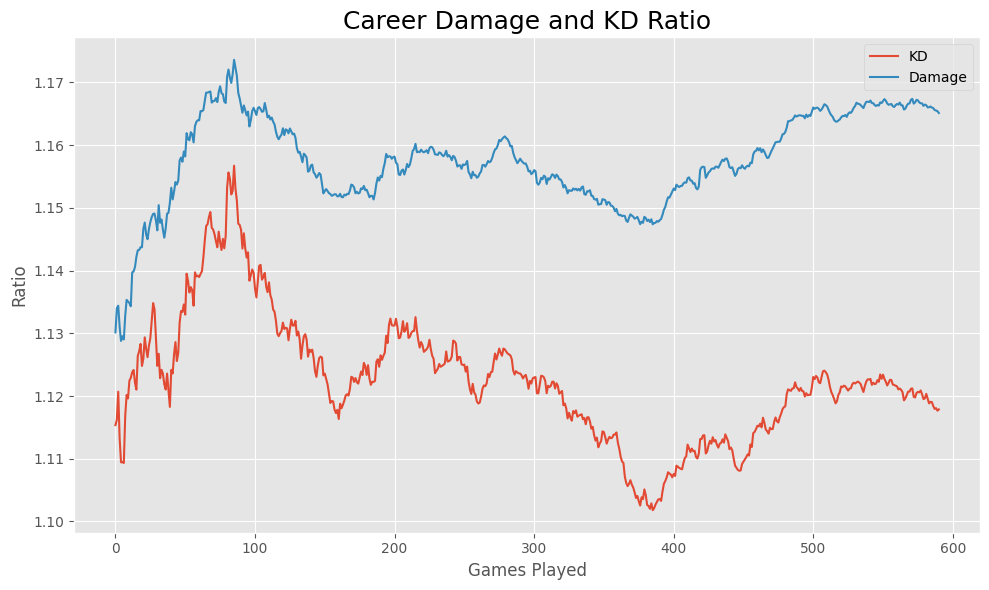

In [7]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

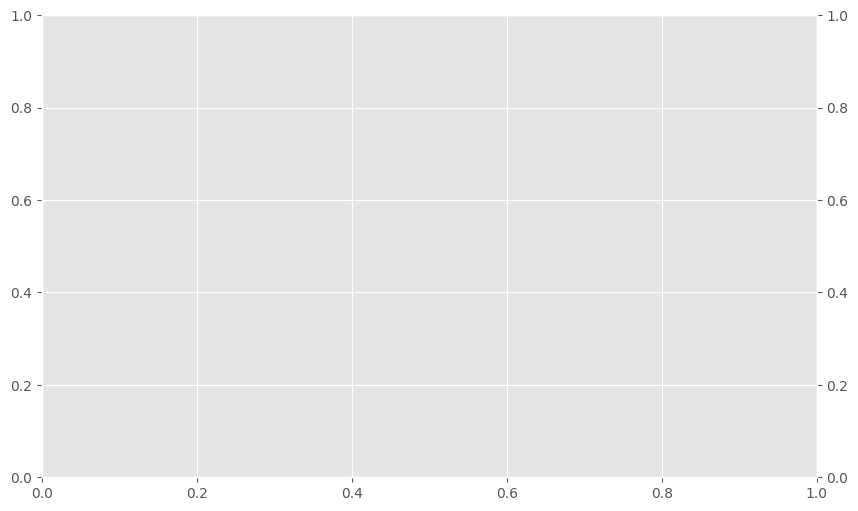

In [8]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

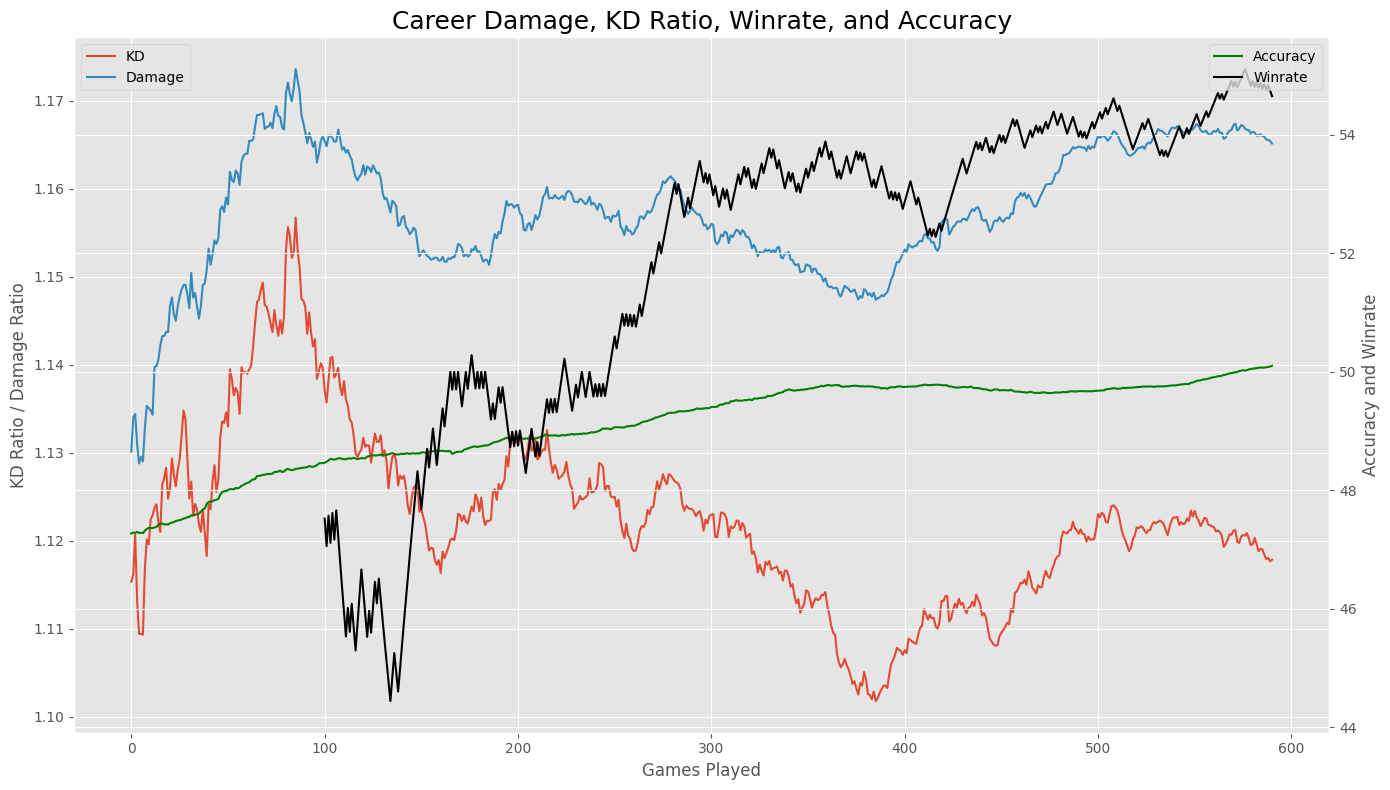

In [9]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

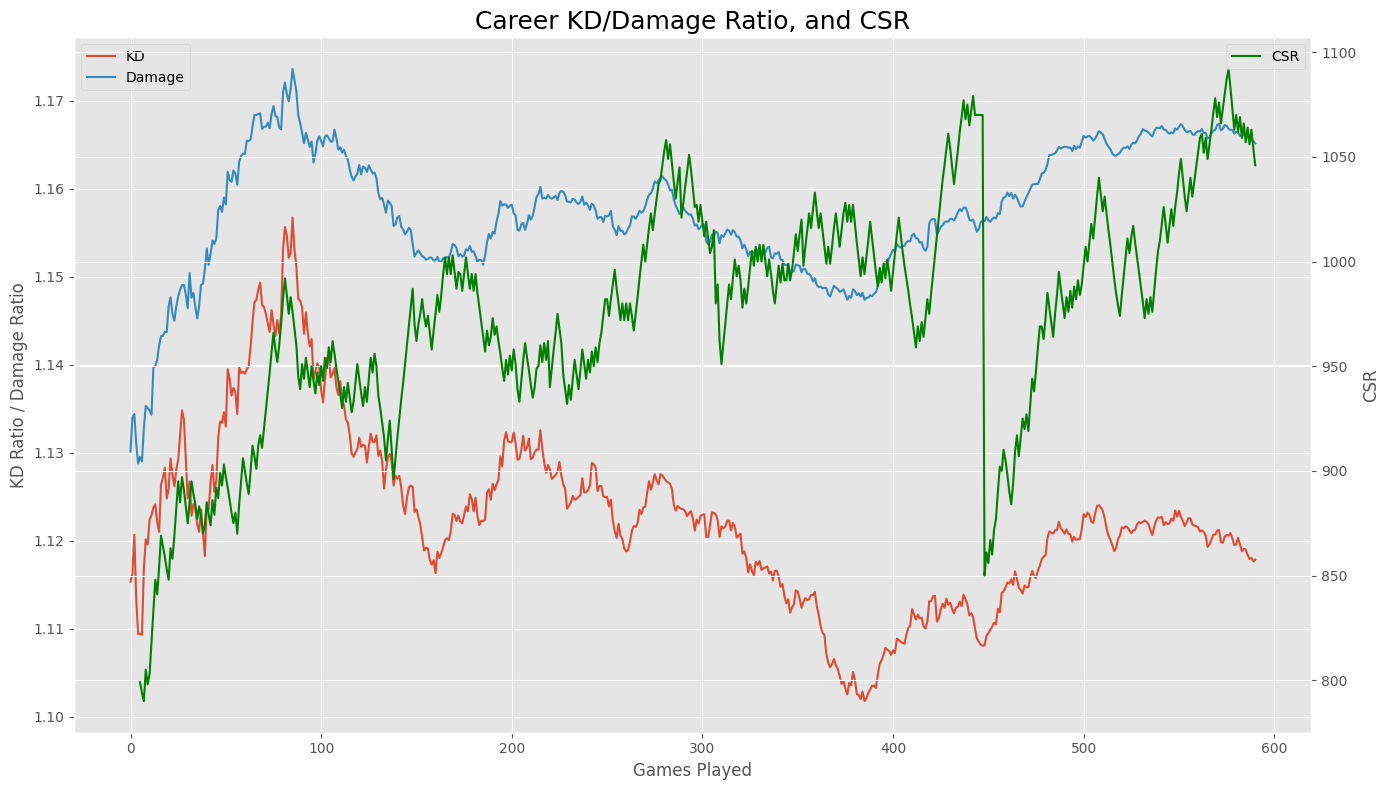

In [10]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

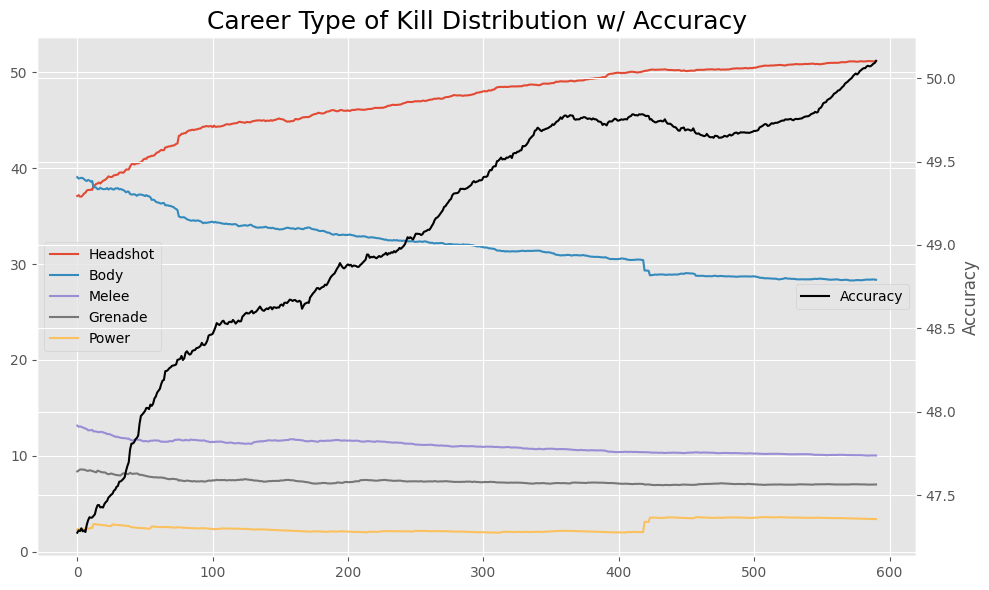

In [11]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

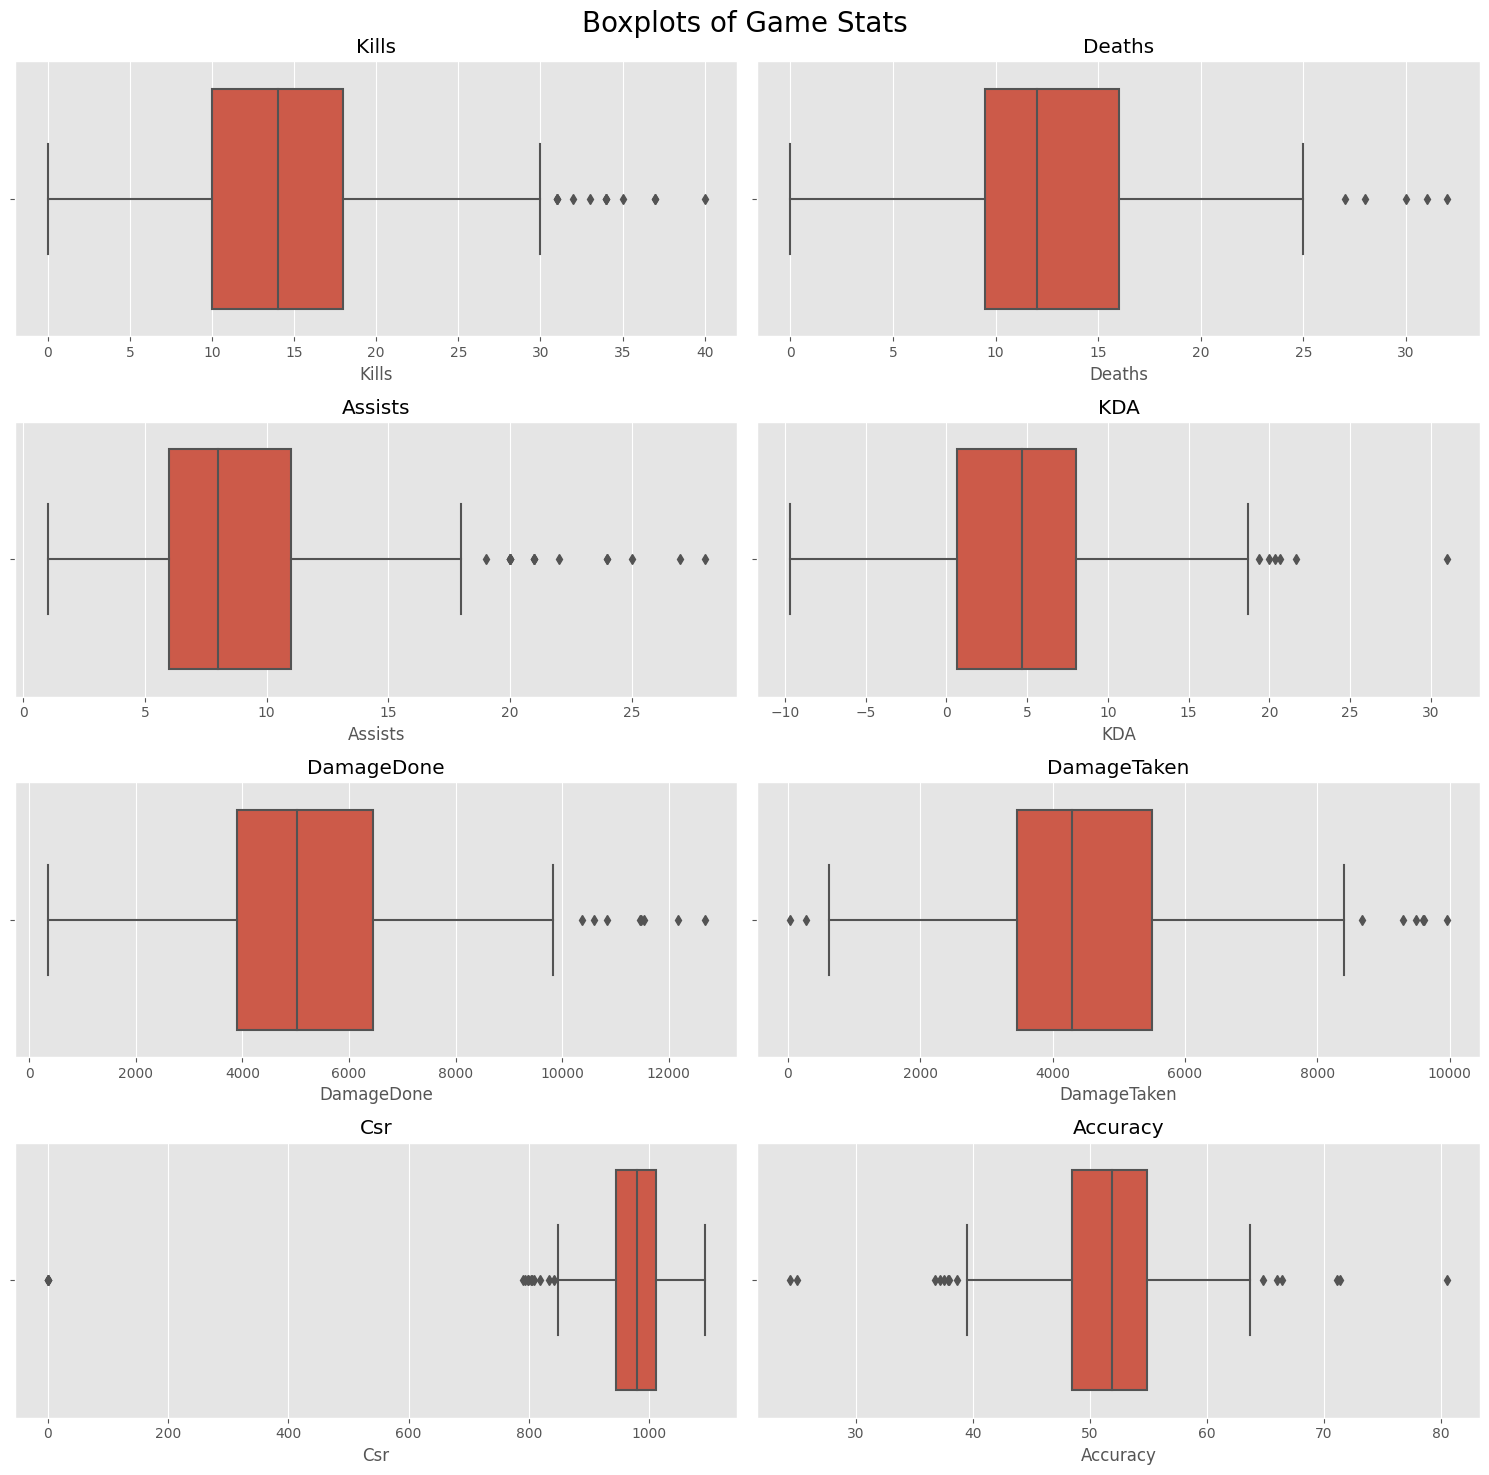

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [31]:
# Last * Games

mod = 10
dfmod = dfr.tail(mod)

# dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.04
Accuracy: 53.75
Damage Ratio: 1.09
Win-Loss: 4-6
Winrate: 0.67
Max CSR: 1069


In [32]:
import plotly.express as px

fig = px.line(df, x=df.index, y=df['Accuracy'].rolling(window=20).mean(), 
              labels={'x': 'Number of Games Played', 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [15]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.15
Average Kills: 13.73
Average Deaths: 11.98
Average Assists: 8.03
Average Accuracy: 51.63
Average Damage Done: 5244
Average Damage Taken: 4466
Damage Ratio: 1.17
Dmg Done <> Taken: 20-131
Win-Loss: 323-268
----------------------------
Totals
Total Games: 591
Total Kills: 8646
Total Deaths: 7604
Total Assists: 5023
----------------------------
Wins
Overall KD: 1.32
Average Kills: 14.22
Average Deaths: 10.75
Average Assists: 8.53
Average Accuracy: 51.88
Average Damage Done: 5078
Average Damage Taken: 4109
Damage Ratio: 1.24
Wins: 323
----------------------------
Losses
Overall KD: 0.97
Average Kills: 13.13
Average Deaths: 13.47
Average Assists: 7.43
Average Accuracy: 51.35
Average Damage Done: 5444
Average Damage Taken: 4896
Damage Ratio: 1.11
Losses: 268


In [16]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 123
Games Ranked 5: 136
MVP %: 43.82


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [17]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [18]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>1].count())
print(gamiPiv[gamiPiv.values>1].sort_values(ascending=False))


Records with >= 3 Scori: 46
Scorigami
15-8-7      3
8-11-5      3
7-12-7      3
6-11-8      3
19-18-10    3
20-12-6     2
17-13-10    2
17-14-5     2
17-15-9     2
17-16-10    2
17-16-11    2
17-17-3     2
17-18-8     2
24-19-6     2
21-18-9     2
10-11-5     2
7-10-4      2
7-11-6      2
7-12-4      2
7-8-7       2
8-8-7       2
9-10-5      2
16-11-8     2
10-10-3     2
15-13-8     2
15-11-8     2
10-11-6     2
10-5-7      2
10-7-1      2
10-7-5      2
11-12-7     2
11-14-7     2
11-15-8     2
11-8-7      2
12-10-6     2
12-15-7     2
12-8-9      2
13-10-6     2
13-11-9     2
13-14-10    2
14-10-11    2
14-11-8     2
14-14-7     2
15-10-14    2
15-11-10    2
9-11-3      2
dtype: int64


In [19]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1183.40,138,19.06,23.35
Strongholds,1066.22,90,17.17,15.23
Oddball,1047.93,86,16.88,14.55
CTF 3 Captures,996.60,91,16.05,15.40
King of the Hill,918.33,84,14.79,14.21
Extraction,611.85,70,9.86,11.84
CTF 5 Captures,384.02,32,6.19,5.41


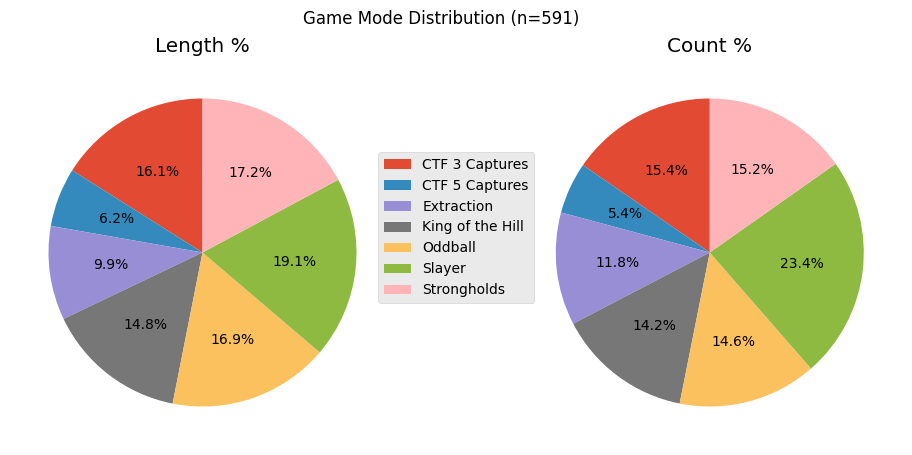

In [20]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [21]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      40         8.36     0.45    6.77     8.08
King of the Hill Recharge      40         7.65     0.50    6.77     7.39
Oddball          Streets       35         7.10     0.63    5.92     6.86
CTF 3 Captures   Empyrean      34         6.60     0.41    5.75     6.38
CTF 5 Captures   Aquarius      32         6.40     0.47    5.41     6.19
Slayer           Solitude      42         6.16     0.62    7.11     5.95
                 Aquarius      40         5.67     0.57    6.77     5.48
CTF 3 Captures   Argyle        29         5.47     0.45    4.91     5.29
Oddball          Recharge      27         5.41     0.56    4.57     5.23
                 Live Fire     24         4.96     0.62    4.06     4.79
Strongholds      Live Fire     26         4.82     0.54    4.40     4.66
Extraction       Streets       33         4.74     0.61    5.58     4.58
Strongholds      Recharge      24         4.59     0.42    4.06     4.44
CTF 3 Captures   Forbidden     28         4.54     0.64    4.74     4.39
King of the Hill Solitude      21         3.99     0.52    3.55     3.86
                 Live Fire     23         3.66     0.78    3.89     3.54
Slayer           Live Fire     21         3.02     0.52    3.55     2.92
                 Streets       22         2.93     0.59    3.72     2.83
Extraction       Recharge      18         2.76     0.61    3.05     2.67
                 Live Fire     19         2.70     0.42    3.21     2.61
Slayer           Recharge      13         1.94     0.62    2.20     1.87

In [22]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Kills/10Min', 'Category', 'Map'], ascending=False),2)
# dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Extraction       Streets       33    453     351      253      147191   
King of the Hill Solitude      21    378     301      211      125129   
CTF 5 Captures   Aquarius      32    604     461      310      209780   
Strongholds      Solitude      40    771     647      463      261117   
King of the Hill Live Fire     23    333     309      167      112699   
                 Recharge      40    681     606      477      249306   
Oddball          Streets       35    621     554      377      217844   
Strongholds      Live Fire     26    414     343      185      141389   
Oddball          Recharge      27    461     381      284      164882   
Extraction       Live Fire     19    230     216      125       82363   
                 Recharge      18    230     193      143       80159   
CTF 3 Captures   Forbidden     28    370     267      173      131088   
                 Empyrean      34    528     493      263      190108   
Oddball          Live Fire     24    393     397      270      148667   
Strongholds      Recharge      24    356     343      223      133296   
CTF 3 Captures   Argyle        29    420     361      202      152175   
Slayer           Aquarius      40    416     402      262      164652   
                 Solitude      42    448     446      292      173771   
                 Live Fire     21    217     211      116       79264   
                 Streets       22    197     204      143       82113   
                 Recharge      13    125     118       84       52217   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
Extraction       Streets         118482     0.61         284.25     54.27   
King of the Hill Solitude        103909     0.52         239.67     51.93   
CTF 5 Captures   Aquarius        163115     0.47         384.02     52.39   
Strongholds      Solitude        218865     0.45         501.55     53.09   
King of the Hill Live Fire       101705     0.78         219.80     53.65   
                 Recharge        209561     0.50         458.87     50.58   
Oddball          Streets         185620     0.63         425.78     53.70   
Strongholds      Live Fire       123367     0.54         289.20     53.56   
Oddball          Recharge        135831     0.56         324.47     50.19   
Extraction       Live Fire        72351     0.42         162.17     55.24   
                 Recharge         66596     0.61         165.43     51.43   
CTF 3 Captures   Forbidden        99128     0.64         272.45     51.92   
                 Empyrean        169702     0.41         396.23     51.51   
Oddball          Live Fire       128568     0.62         297.68     52.10   
Strongholds      Recharge        116330     0.42         275.47     48.86   
CTF 3 Captures   Argyle          125144     0.45         327.92     50.15   
Slayer           Aquarius        146617     0.57         340.22     51.10   
                 Solitude        158862     0.62         369.72     49.93   
                 Live Fire        75141     0.52         181.30     49.84   
                 Streets          73731     0.59         175.63     48.88   
                 Recharge         46598     0.62         116.53     47.31   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
Extraction       Streets    1.29         1.24    419.35       81.79   
King of the Hill Solitude   1.26         1.20    415.71       70.50   
CTF 5 Captures   Aquarius   1.31         1.29    455.05      101.23   
Strongholds      Solitude   1.19         1.19    403.58       65.30   
King of the Hill Live Fire  1.08         1.11    364.72       35.58   
                 Recharge   1.12         1.19    411.40       65.59   
Oddball 

In [23]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
King of the Hill,84,1392,1216,855,487134,415175,0.58,1.14,1.17,400.60,59.18,0.70
Oddball,86,1475,1332,931,531393,450019,0.60,1.11,1.18,398.94,61.09,0.70
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
CTF 5 Captures,32,604,461,310,209780,163115,0.47,1.31,1.29,455.05,101.23,0.67
Strongholds,90,1541,1333,871,535802,458562,0.47,1.16,1.17,401.95,57.94,0.65
Slayer,138,1403,1381,897,552017,500949,0.59,1.02,1.10,399.72,36.98,0.65
CTF 3 Captures,91,1318,1121,638,473371,393974,0.49,1.18,1.20,422.28,70.83,0.57


In [24]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,122,1853,1641,1211,679860,574916,0.52,1.13,1.18,414.30,63.95,0.74
Streets,90,1271,1109,773,447148,377833,0.61,1.15,1.18,403.20,62.50,0.70
Solitude,103,1597,1394,966,560017,481636,0.53,1.15,1.16,401.73,56.23,0.69
Aquarius,72,1020,863,572,374432,309732,0.53,1.18,1.21,433.87,74.97,0.66
Forbidden,28,370,267,173,131088,99128,0.64,1.39,1.32,490.97,119.70,0.65
Live Fire,113,1587,1476,863,564382,501132,0.58,1.08,1.13,382.37,42.85,0.58
Argyle,29,420,361,202,152175,125144,0.45,1.16,1.22,421.54,74.88,0.56
Empyrean,34,528,493,263,190108,169702,0.41,1.07,1.12,385.61,41.39,0.53


In [25]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.74571108300006s
